In [2]:
import json
import os
import pandas as pd

#results_dir = "../evalScripts/webshop/manualOptimizerConstantLoad/statistics/highload-bursty_workload-3"
#results_dir = "../evalScripts/webshop/generateConfigurations/statistics/everything-m-15-x-60-x-3"
#results_dir = "../evalScripts/split/generateConfigurations/statistics/testcpu88moremem-A-8-x-15-x-10"
results_dir = "../evalScripts/webshop/generateConfigurations/statistics/fixedcheckout-m-4-x-111-x-3"
json_files = [pos_json for pos_json in os.listdir(results_dir) if "json" in pos_json and "configuration" not in pos_json]

data = []
for index, json_fn in enumerate(json_files):
    with open(os.path.join(results_dir, json_fn)) as in_file:
        fusion_group = json_fn.removesuffix('.json')
        content = json.load(in_file)
        print(f'Read fusion group {fusion_group} with {len(content)} lines')
        data.extend(content)
configuration_metadata = []
with open(os.path.join(results_dir, "configuration/configurationMetadata.json")) as in_file:
    configuration_metadata = pd.DataFrame.from_dict(json.load(in_file))

Read fusion group 1676376883 with 6356 lines
Read fusion group 1676390159 with 3007 lines
Read fusion group 1676378281 with 5354 lines
Read fusion group 1676379640 with 4352 lines
Read fusion group 1676388535 with 3007 lines
Read fusion group 1676389085 with 3016 lines
Read fusion group 1676377830 with 5688 lines
Read fusion group 1676377347 with 6004 lines
Read fusion group 1676383779 with 4018 lines
Read fusion group 1676376424 with 6356 lines
Read fusion group 1676387708 with 3350 lines
Read fusion group 1676375682 with 6690 lines
Read fusion group 1676383303 with 4018 lines
Read fusion group 1676389591 with 3016 lines
Read fusion group 1676378737 with 5020 lines
Read fusion group 1676379194 with 4344 lines
Read fusion group 1676385324 with 3673 lines


In [3]:
# This is a single invocation
# data[0]
# configuration_metadata["1673023420"]["rules"]["A"]["A"]

In [4]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

sns.set_palette(sns.color_palette("bright"))
sns.set(rc={'figure.figsize':(6,5)}, font_scale=1.0, style='whitegrid', font='CMU Sans Serif')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('axes', unicode_minus=False)

def save_fig(ax, name, file_type="pdf"):
    pass # for testing stuff out, don't acuatlly generate the plots...
    #fig = ax.get_figure()
    #fig.tight_layout()
    #file_name = name + "." + file_type
    #fig.savefig(os.path.join("graphs", file_name), bbox_inches='tight')

df = pd.DataFrame.from_dict(data)
df["memoryAvail"] = pd.to_numeric(df["memoryAvail"])

# Get the smallest Start timestamp and remove it from every timestamp value
min_start_timestamp = df["startTimestamp"].min()
df["startTimestamp"] = df["startTimestamp"] - min_start_timestamp
df["endTimestamp"] = df["endTimestamp"] - min_start_timestamp
df["duration"] =  df["endTimestamp"] - df["startTimestamp"]
df["totalCost"] = 0.0000166667 * 0.000001 * df["memoryAvail"].astype(float) * df["billedDuration"].astype(float)


In [5]:
print(f'Unique Invocations: {df["traceId"].nunique()}')

Unique Invocations: 17104


In [6]:
# Now do not count every invocation, but sort the df by the cost of trace
grouped = df.groupby('traceId').agg({'billedDuration': ['sum'], 'startTimestamp': ['min'], 'endTimestamp': ['max'], 'fusionGroup': 'min', 'totalCost': 'sum', 'memoryAvail': ['min']})
#grouped['numInvocations'] = df.groupby('traceId').count()
grouped['numInvocations'] = df.groupby('traceId').size()
print(f'Total Number of Invocations should be: {grouped["numInvocations"].sum()} == {len(df.index)}')

# Grouped: Get Root Invocation of TraceId and get rootEndTimestamp
# Pandas join() oder merge() machen mit dem alten Dataframe. Merge ist einfacher
rootInvocations = df[df["isRootInvocation"]][["traceId", "endTimestamp"]].rename(columns={"endTimestamp": "rootEndTimestamp"})
grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")
grouped["rootDuration"] = grouped["rootEndTimestamp"] - grouped["startTimestamp", "min"]

#grouped

Total Number of Invocations should be: 77269 == 77269


/tmp/ipykernel_87046/3713967382.py:10: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


In [7]:
grouped[grouped["rootDuration"] <= 1000]

,traceId,"(billedDuration, sum)","(startTimestamp, min)","(endTimestamp, max)","(fusionGroup, min)","(totalCost, sum)","(memoryAvail, min)","(numInvocations, )",rootEndTimestamp,rootDuration
0,1676375682-addcartitem-128-01fb28efb159cec5391...,331,34095,34454,1676375682,7.061347e-07,128,2,34130,35
1,1676375682-addcartitem-128-03e90c7cb0ca012237a...,968,6097,7082,1676375682,2.065071e-06,128,2,6502,405
2,1676375682-addcartitem-128-04c59a644c14238d356...,563,6507,7153,1676375682,1.201069e-06,128,2,6567,60
3,1676375682-addcartitem-128-0501319bc3b587453f1...,656,91426,92110,1676375682,1.399469e-06,128,2,91467,41
4,1676375682-addcartitem-128-05cc8bfc7f54e5c0730...,357,52113,52498,1676375682,7.616015e-07,128,2,52154,41
...,...,...,...,...,...,...,...,...,...,...
17099,1676390159-frontend-128-fd63955945f0848030de5d...,99,14485274,14485372,1676390159,2.112004e-07,128,1,14485372,98
17100,1676390159-frontend-128-fe42996f531c7484b65ac8...,77,14528861,14528937,1676390159,1.642670e-07,128,1,14528937,76
17101,1676390159-frontend-128-fe79f225f82771b13ae52f...,2129,14457766,14459105,1676390159,4.765023e-05,128,6,14457862,96
17102,1676390159-frontend-128-fe7dbd3e184b865ffd558c...,77,14525982,14526057,1676390159,1.642670e-07,128,1,14526057,75


[1676375682 1676376424 1676376883 1676377347 1676377830 1676378281
 1676378737 1676379194 1676379640 1676383303 1676383779 1676385324
 1676387708 1676388535 1676389085 1676389591 1676390159]


<AxesSubplot: xlabel="('fusionGroup', 'min')", ylabel="('billedDuration', 'sum')">

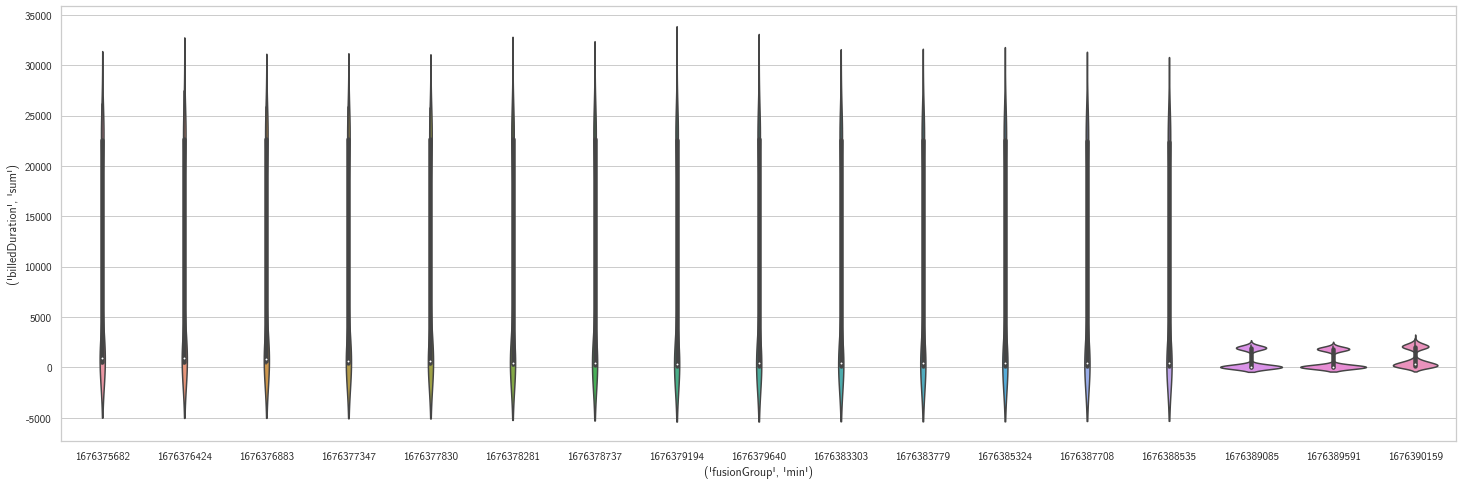

In [8]:
plt.figure(figsize=(25,8))
fusion_groups_order = pd.unique(grouped.sort_values(by="rootEndTimestamp")['fusionGroup', 'min'])
print(fusion_groups_order)
sns.violinplot(data=grouped, x=grouped['fusionGroup', 'min'] , y=grouped['billedDuration', 'sum'], order=fusion_groups_order)
#plt.savefig("violinBilled.pdf")

[1676375682 1676376424 1676376883 1676377347 1676377830 1676378281
 1676378737 1676379194 1676379640 1676383303 1676383779 1676385324
 1676387708 1676388535 1676389085 1676389591 1676390159]


<AxesSubplot: xlabel="('fusionGroup', 'min')", ylabel='rootDuration'>

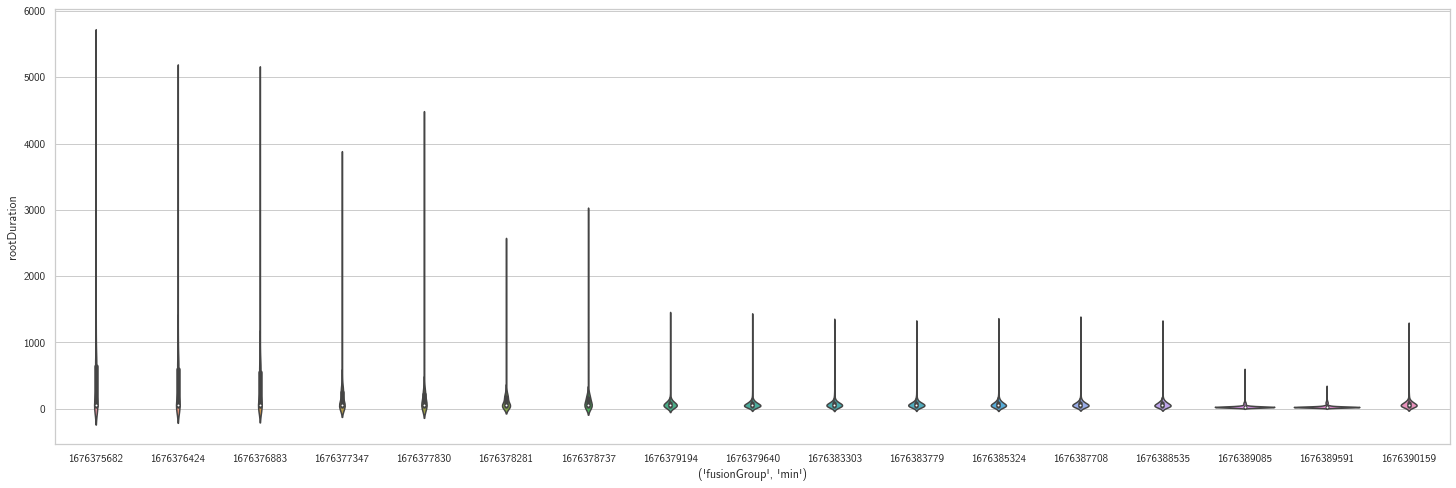

In [9]:
plt.figure(figsize=(25,8))
fusion_groups_order = pd.unique(grouped.sort_values(by="rootEndTimestamp")['fusionGroup', 'min'])
print(fusion_groups_order)
sns.violinplot(data=grouped, x=grouped['fusionGroup', 'min'] , y=grouped['rootDuration'], order=fusion_groups_order)
#plt.savefig("violinRR.pdf")

/tmp/ipykernel_87046/1827506857.py:1: UserWarning: 
The palette list has fewer values (10) than needed (17) and will cycle, which may produce an uninterpretable plot.
  ax = sns.ecdfplot(data=grouped, x=grouped['billedDuration', 'sum'], hue=grouped['fusionGroup', 'min'], hue_order=fusion_groups_order, palette=sns.color_palette("bright"))


Text(0.5, 0, 'billed duration [ms]')

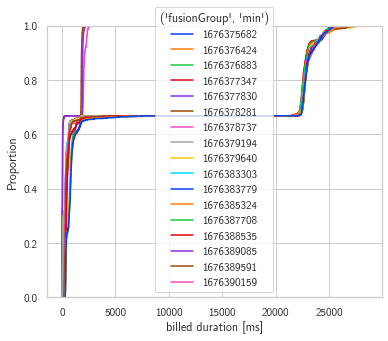

In [10]:
ax = sns.ecdfplot(data=grouped, x=grouped['billedDuration', 'sum'], hue=grouped['fusionGroup', 'min'], hue_order=fusion_groups_order, palette=sns.color_palette("bright"))
plt.xlabel("billed duration [ms]")
#ax.get_legend().set_title("Fusion Setup")
#ax.set(xlim=(1800,6000))
#plt.savefig("ecdfBilled.pdf")

/tmp/ipykernel_87046/3156828276.py:1: UserWarning: 
The palette list has fewer values (10) than needed (17) and will cycle, which may produce an uninterpretable plot.
  ax = sns.ecdfplot(data=grouped, x=grouped['rootDuration'], hue=grouped['fusionGroup', 'min'], hue_order=fusion_groups_order, palette=sns.color_palette("bright"))


Text(0.5, 0, 'request response latency [ms]')

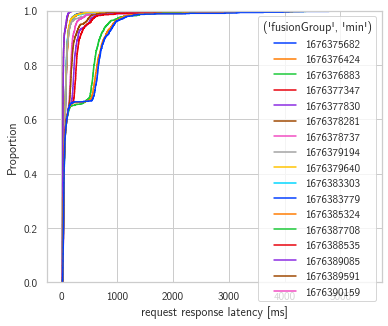

In [11]:
ax = sns.ecdfplot(data=grouped, x=grouped['rootDuration'], hue=grouped['fusionGroup', 'min'], hue_order=fusion_groups_order, palette=sns.color_palette("bright"))
plt.xlabel("request response latency [ms]")
#ax.get_legend().set_title("Fusion Group")
#ax.set(xlim=(00,500))
#plt.savefig("ecdfRR.pdf")

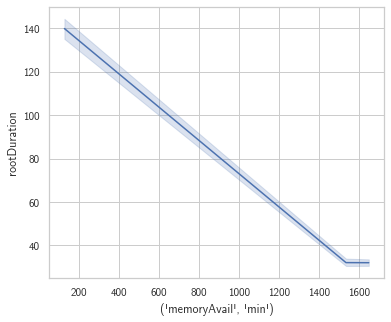

In [12]:
ax = sns.lineplot(data=grouped, y=grouped['rootDuration'], x=grouped['memoryAvail', 'min'])

/tmp/ipykernel_87046/3414157403.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  ax = sns.ecdfplot(data=grouped, x=grouped['rootDuration'], hue=grouped['memoryAvail', 'min'], palette=sns.color_palette("bright"))


Text(0.5, 0, 'request response latency [ms]')

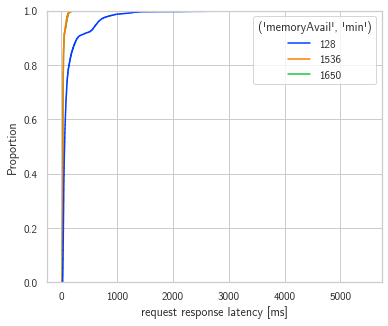

In [13]:
ax = sns.ecdfplot(data=grouped, x=grouped['rootDuration'], hue=grouped['memoryAvail', 'min'], palette=sns.color_palette("bright"))
plt.xlabel("request response latency [ms]")
#ax.get_legend().set_title("Fusion Group")
#ax.set(xlim=(00,500))

/tmp/ipykernel_87046/1709290084.py:1: UserWarning: 
The palette list has fewer values (12) than needed (17) and will cycle, which may produce an uninterpretable plot.
  ax = sns.ecdfplot(data=grouped, x=grouped['totalCost', 'sum'], hue=grouped['fusionGroup', 'min'], hue_order=fusion_groups_order, palette=sns.color_palette("bright",12))


Text(0.5, 0, 'total cost [$]')

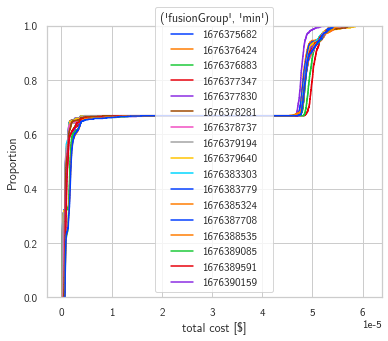

In [14]:
ax = sns.ecdfplot(data=grouped, x=grouped['totalCost', 'sum'], hue=grouped['fusionGroup', 'min'], hue_order=fusion_groups_order, palette=sns.color_palette("bright",12))
plt.xlabel("total cost [$]")
#ax.get_legend().set_title("Fusion Group")
#ax.set(xlim=(0,0.000005))
#plt.savefig("ecdfDollar.pdf")

In [15]:
from scipy.stats import t

In [16]:
# Calculate Mean and Confidence Interval of billed duration and rootDuration

def printMeanAndCi(x, name=""):
    m = x.mean() 
    s = x.std() 
    dof = len(grouped)-1 
    confidence = 0.95

    t_crit = np.abs(t.ppf((1-confidence)/2,dof))
    print(f'Mean: {m}, Confidence Interval: ({m-s*t_crit/np.sqrt(len(x))} / {m+s*t_crit/np.sqrt(len(x))}), Median: {x.median()} for {name}')

print("overall")
printMeanAndCi(grouped["rootDuration"], "rootDuration")
printMeanAndCi(grouped['billedDuration', 'sum'], "billedDuration")
for group in fusion_groups_order:
    filtered = grouped[grouped['fusionGroup', 'min'] == group]
    print(group)
    #printMeanAndCi(filtered["rootDuration"], f'rootDuration')
    #printMeanAndCi(filtered['billedDuration', 'sum'], f'billedDuration')
    printMeanAndCi(filtered['totalCost', 'sum'], f'totalCost')

overall
Mean: 127.20164873713752, Confidence Interval: (123.19741390894237 / 131.20588356533267), Median: 51.0 for rootDuration
Mean: 6715.585301683816, Confidence Interval: (6564.247379722767 / 6866.923223644866), Median: 559.0 for billedDuration
1676375682
Mean: 1.756597806468957e-05, Confidence Interval: (1.617411759855617e-05 / 1.8957838530822972e-05), Median: 1.9349372032e-06 for totalCost
1676376424
Mean: 1.7542752861006554e-05, Confidence Interval: (1.6148396808064277e-05 / 1.8937108913948832e-05), Median: 1.8986704640000001e-06 for totalCost
1676376883
Mean: 1.7525622604965243e-05, Confidence Interval: (1.612918499050585e-05 / 1.8922060219424637e-05), Median: 1.7749368832e-06 for totalCost
1676377347
Mean: 1.7228632597966535e-05, Confidence Interval: (1.5822747513353197e-05 / 1.8634517682579873e-05), Median: 1.2810692288e-06 for totalCost
1676377830
Mean: 1.7246941345849456e-05, Confidence Interval: (1.5843323466682358e-05 / 1.8650559225016554e-05), Median: 1.2650691968000002e-

In [17]:
calls = df["calls"]
calls = np.concatenate(list(calls)).ravel()
calledI = np.array(list(filter(lambda el: el["called"] == "I", calls)))
#df["acutalInternalDuration"] = df.apply(lambda row: np.vectorize(lambda obj: obj["time"])(np.array(list(filter(lambda el: el["called"] == "I",np.concatenate(list(row["calls"])).ravel())))), axis=1)

#df.apply(lambda row: np.vectorize(lambda obj: obj["time"])(np.array(list(filter(lambda el: el["called"] == "I",np.concatenate(list(row["calls"])).ravel())))), axis=1)
#np.vectorize(lambda obj: obj["time"])(calledI)

In [18]:
def get_call_time_for_row(row):
    calls = list(np.array(row["calls"]).flat)
    #calls = np.concatenate(calls).ravel()
    calledI = np.array(list(filter(lambda el: el["called"] == el["caller"], calls)))
    return  calledI[0]["time"] if len(calledI) > 0 else -1
df["actualInternalDuration"] = df.apply(lambda row: get_call_time_for_row(row), axis=1)

all: mean: 128.9773906741384 median: 2.0 stdev: 454.79406724101824 25perc: 1.0 75perc: 39.0 90perc: 114.0 99perc: 2400.3199999999924 max:5230 len: 77269 coldMean: 317.53442570281123 coldStd: 673.7583876576571 warmMean: 1.7921073162274619 warmStd: 1.7384931520521887



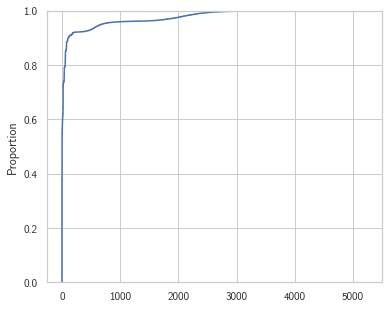

root: mean: 5.89300748362956 median: 1.0 stdev: 13.178613669603045 25perc: 1.0 75perc: 3.0 90perc: 19.0 99perc: 60.0 max:342 len: 17104 coldMean: 27.04773779836124 coldStd: 22.544227563016 warmMean: 1.7395957193816884 warmStd: 1.7021398293997192



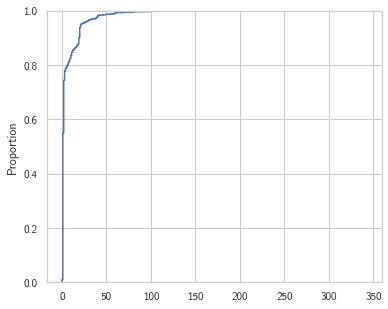

In [19]:
# Calculate the overhead of the handler

def calculate_handler_overhead(df, name = ""):
    # df = df[df["actualInternalDuration"] >= 0]
    oh = df["duration"] - df["actualInternalDuration"]
    warm = oh[oh <= 10]#oh[df["isColdStart"] == False]
    cold = oh[oh > 10]#oh[df["isColdStart"] == True]
    print(f'{name}: mean: {oh.mean()} median: {oh.median()} stdev: {oh.std()} 25perc: {oh.quantile(0.25)} 75perc: {oh.quantile(0.75)} 90perc: {oh.quantile(0.90)} 99perc: {oh.quantile(0.99)} max:{oh.max()} len: {len(oh)} coldMean: {cold.mean()} coldStd: {cold.std()} warmMean: {warm.mean()} warmStd: {warm.std()}\n')
    sns.ecdfplot(data=df, x=df["duration"] - df["actualInternalDuration"])
    plt.show()

calculate_handler_overhead(df, "all")
calculate_handler_overhead(df[df['isRootInvocation'] == True], "root")

/tmp/ipykernel_87046/2975012194.py:5: UserWarning: 
The palette list has fewer values (10) than needed (17) and will cycle, which may produce an uninterpretable plot.
  ax = sns.ecdfplot(data=coldstarts, x="totalCost", hue="fusionGroup", hue_order=fusion_groups_order, palette=sns.color_palette("bright"))


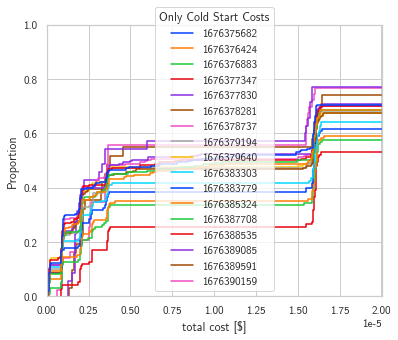

In [20]:
if not df["isColdStart"].isna().any(): # Some older tests don't have this unfortunately
    coldstarts = df.loc[df["isColdStart"]]
    #coldstarts = coldstarts.loc[coldstarts["isRootInvocation"]]

    ax = sns.ecdfplot(data=coldstarts, x="totalCost", hue="fusionGroup", hue_order=fusion_groups_order, palette=sns.color_palette("bright"))
    plt.xlabel("total cost [$]")
    ax.get_legend().set_title("Only Cold Start Costs")
    ax.set(xlim=(0.0,0.00002))
    #plt.savefig("ecdfDollar.pdf")


/tmp/ipykernel_87046/449458112.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.ecdfplot(data=invocations, x="totalCost", hue="memoryAvail", palette=sns.color_palette("bright", 9))


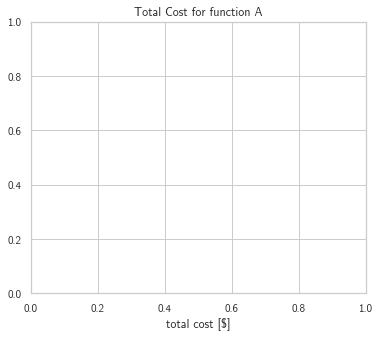

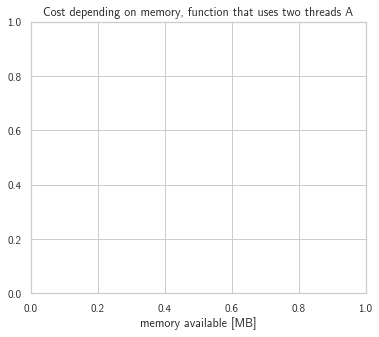

/tmp/ipykernel_87046/449458112.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.ecdfplot(data=invocations, x="totalCost", hue="memoryAvail", palette=sns.color_palette("bright", 9))


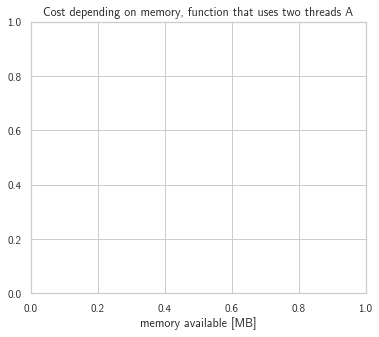

/tmp/ipykernel_87046/449458112.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.ecdfplot(data=invocations, x="totalCost", hue="memoryAvail", palette=sns.color_palette("bright", 9))


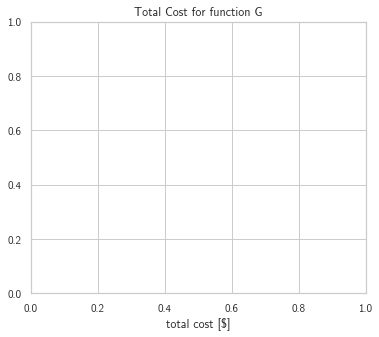

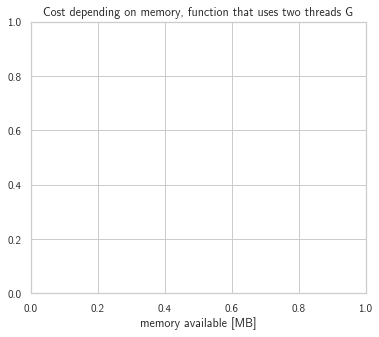

/tmp/ipykernel_87046/449458112.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.ecdfplot(data=invocations, x="totalCost", hue="memoryAvail", palette=sns.color_palette("bright", 9))


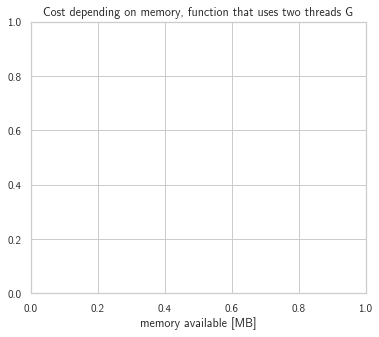

In [21]:
def show_diff_memory_cost(df, function_name, fixForSize = False, fixForSizeGroup = ""):
    invocations = df.loc[df["currentTask"] == function_name]
    if fixForSize:
        #invocations = invocations.query("fusionGroup == @fixForSizeGroup | memoryAvail != @fixForSizeSize")
        invocations["fusionGroup"] = pd.to_numeric(invocations["fusionGroup"])
        invocations = invocations.query("fusionGroup >= @fixForSizeGroup")
    sizes = invocations["memoryAvail"].unique()
    sns.ecdfplot(data=invocations, x="totalCost", hue="memoryAvail", palette=sns.color_palette("bright", 9))
    plt.title(f"Total Cost for function {function_name}")
    plt.xlabel("total cost [$]")
    plt.show()
    sns.lineplot(data=invocations, x="memoryAvail", y="totalCost")
    plt.title(f"Cost depending on memory, function that uses two threads {function_name}")
    plt.xlabel("memory available [MB]")
    plt.show()
    sns.ecdfplot(data=invocations, x="totalCost", hue="memoryAvail", palette=sns.color_palette("bright", 9))
    plt.title(f"Cost depending on memory, function that uses two threads {function_name}")
    plt.xlabel("memory available [MB]")
    plt.show()

#show_diff_memory_cost(df, "checkout", True, 1674508777)
#show_diff_memory_cost(df, "shiporder")
show_diff_memory_cost(df, "A", False, 1675346654)
show_diff_memory_cost(df, "G", False, 1675346654)

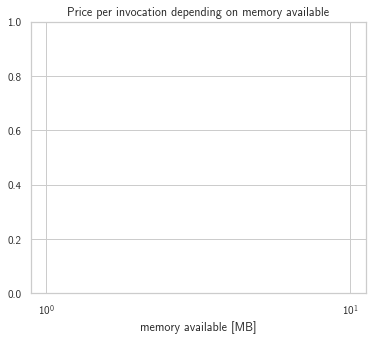

In [22]:
def compare_memory_cost(df, function_name, other_function, fixForSizeGroup = 0):

    invocations1 = df.loc[df["currentTask"] == function_name]
    invocations1["fusionGroup"] = pd.to_numeric(invocations1["fusionGroup"])
    invocations1 = invocations1.query("fusionGroup >= @fixForSizeGroup")
    sizes = invocations1["memoryAvail"].unique()

    invocations2 = df.loc[df["currentTask"] == other_function]
    invocations2["fusionGroup"] = pd.to_numeric(invocations2["fusionGroup"])
    invocations2 = invocations2.query("fusionGroup >= @fixForSizeGroup")


    #sns.lineplot(data=invocations1, x="memoryAvail", y="totalCost", label="lightweight")
    #sns.lineplot(data=invocations2, x="memoryAvail", y="totalCost", label="cpu-bound")
    sns.lineplot(data=invocations1, x="memoryAvail", y="totalCost", label="lightweight")
    sns.lineplot(data=invocations2, x="memoryAvail", y="totalCost", label="cpu-bound")
    plt.title(f"Price per invocation depending on memory available")
    plt.xlabel("memory available [MB]")
    #plt.ylim((0, 0.00004))
    plt.xscale("log")
    plt.show()
compare_memory_cost(df, "A", "C", 1675346654)

<AxesSubplot: xlabel='fusionGroup', ylabel='totalCost'>

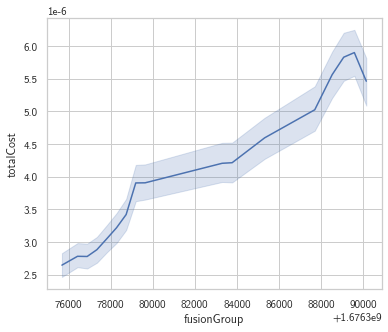

In [23]:
sns.lineplot(data=df, x="fusionGroup", y="totalCost")